# Constrained Orthogonal Matching Pursuit for Audio Declipping

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.signal as sig
import scipy.optimize as opt
import scipy.io as sio
import kagglehub as kh
import cvxpy as cp

## Signal Clipping

In [6]:
def clip(s, theta_clip : float):
    """ 
    Clips a signal s to the range [-theta_clip, theta_clip]
    """
    return np.clip(s, -theta_clip, theta_clip)

In [7]:
def get_theta_clip(y):
    """ 
    Returns the clipping threshold for a clipped signal y
    """
    return np.max(np.abs(y))

In [8]:
def get_M_r(y, theta_clip : float = None):
    """
    Returns the measurement matrix M_r for a clipped signal y
    s.t y_r = M_r * s
    """
    N = y.shape[0]
    M_r = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_r = np.abs(y) < theta_clip           
    M_r = M_r[I_r, :]
    return M_r

In [9]:
def get_M_m(y, theta_clip : float = None):
    """""
    Returns the matrix M_m for a clipped signal y
    s.t y_m = M_m * sign(s) * s (complement of M_r)
    """""
    N = y.shape[0]
    M_m = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m = np.abs(y) >= theta_clip
    M_m = M_m[I_m, :]
    return M_m

In [10]:
def get_M_m_plus(y, theta_clip : float = None):
    """
    Returns the matrix M_m_plus (which gives the indices at which the signal is clipped from above) for a clipped signal y
    """
    N = y.shape[0]
    M_m_plus = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m_plus = y >= theta_clip           
    M_m_plus = M_m_plus[I_m_plus, :]
    return M_m_plus

In [11]:
def get_M_m_minus(y, theta_clip : float = None):
    """
    Returns the matrix M_m_minus (which gives the indices at which the signal is clipped from below) for a clipped signal y
    """
    N = y.shape[0]
    M_m_minus = np.eye(N)
    theta_clip = theta_clip if theta_clip is not None else get_theta_clip(y) 
    I_m_minus = y <= -theta_clip           
    M_m_minus = M_m_minus[I_m_minus, :]
    return M_m_minus

## Gabor Dictionary

In [12]:
params = {
    "sampling_rate": 16000,
    "frame_length": 1024,
    "frame_overlap": 768
}

# Number of atoms per dictionary
K_g = params["frame_length"]//2
# Length of the signal
N = params["frame_length"]

In [24]:
def get_gabor_dictionaries(N : int, K_g : int, weight_window : np.ndarray = np.ones((N, K_g))):
    # Create the time-frequency grid
    T = np.arange(0, N)
    J = np.arange(0, K_g)
    J, T = np.meshgrid(J, T)

    # Dictionaries of shape (N, K_g), 2* K_g atoms in total
    gabor_cosine = weight_window * np.cos(np.pi * (J+1/2) * (T+1/2) / K_g)
    gabor_sine = weight_window * np.sin(np.pi * (J+1/2) * (T+1/2) / K_g)

    return gabor_cosine, gabor_sine

In [25]:
gabor_cosine, gabor_sine = get_gabor_dictionaries(N, K_g)

In [26]:
gabor_cosine.shape, gabor_sine.shape

((1024, 512), (1024, 512))

In [27]:
gabor_cosine

array([[ 0.99999882,  0.99998941,  0.99997059, ...,  0.00766983,
         0.00460193,  0.00153398],
       [ 0.99998941,  0.9999047 ,  0.99973529, ..., -0.02300768,
        -0.01380539, -0.00460193],
       [ 0.99997059,  0.99973529,  0.99926475, ...,  0.03834012,
         0.02300768,  0.00766983],
       ...,
       [-0.99997059, -0.99973529, -0.99926475, ..., -0.03834012,
        -0.02300768, -0.00766983],
       [-0.99998941, -0.9999047 , -0.99973529, ...,  0.02300768,
         0.01380539,  0.00460193],
       [-0.99999882, -0.99998941, -0.99997059, ..., -0.00766983,
        -0.00460193, -0.00153398]])

## Orthogonal Matching Pursuit

In [ ]:
def least_squares(y : np.ndarray, M_r : np.ndarray, Omega : list, D_c : np.ndarray, D_s : np.ndarray, W_c : np.ndarray, W_s : np.ndarray,
                  theta_clip : float = None, theta_max : float = None, M_m_plus : np.ndarray = None, M_m_minus : np.ndarray = None, lambda_reg : float = 0):
    """
    Solves the following least squares problem
        min_{x_c, x_s} ||y - D_c * x_c - D_s * x_s||^2 + lambda * ||x_c||^2 + lambda * ||x_s||^2     s.t.     ...

    Inputs:
    -------
    y : np.ndarray
        The signal to be reconstructed
    M_r : np.ndarray
        The measurement matrix
    Omega : list
        The indices of the measurements
    D_c : np.ndarray
        The dictionary of cosine atoms
    D_s : np.ndarray
        The dictionary of sine atoms
    W_c : np.ndarray
        The window function for the cosine atoms
    W_s : np.ndarray
        The window function for the sine atoms
    theta_clip : float
        The clipping threshold
    theta_max : float
        The maximum amplitude of the signal
    M_m_plus : np.ndarray
        The matrix M_m_plus
    M_m_minus : np.ndarray
        The matrix M_m_minus
    lambda_reg : float
        The regularization parameter

    Outputs:
    --------
    x_c : np.ndarray
        The coefficients of the cosine atoms
    x_s : np.ndarray
        The coefficients of the sine atoms
    """
    y_r = M_r @ y
    D = np.concatenate(((D_c @ W_c)[:,Omega], (D_s @ W_s)[:,Omega]), axis=1)
    D_r = M_r @ D

    if theta_clip is not None or theta_max is not None:
        ## Partie OLS avec contrainte: bcp de bugs encore, marche pas tres bien

        if M_m_plus is None:
            M_m_plus = get_M_m_plus(y, theta_clip)
        if M_m_minus is None:
            M_m_minus = get_M_m_minus(y, theta_clip)

        x = cp.Variable(D_r.shape[1])
        obj = cp.Minimize(cp.sum_squares(y_r - D_r @ x))
        
        constraints = [M_m_plus @ D @ x >= theta_clip, M_m_minus @ D @ x <= - theta_clip] if theta_clip is not None else []      # Min constraints
        constraints += [M_m_plus @ D @ x <= theta_max, M_m_minus @ D @ x >= - theta_max] if theta_max is not None else []        # Max constraints

        prob = cp.Problem(obj, constraints)
        prob.solve()
        if prob.status == 'infeasible':
            print("Infeasible problem")
            x = np.linalg.lstsq(D, y, rcond=None)[0]
        else:
            print('Problem solved')
            x = x.value

    else:
        x = np.linalg.lstsq(D, y, rcond=None)[0]

    x_c = x[:D_c[:,Omega].shape[1]]
    x_s = x[D_c[:,Omega].shape[1]:]
    return x_c, x_s

In [159]:
def OMP(y : np.ndarray, K : int, eps : float, 
        D_c : np.ndarray = gabor_cosine, D_s : np.ndarray = gabor_sine, theta_clip : float = None, theta_max : float = None, verbose : bool = True):
    """ 
    Runs the Orthogonal Matching Pursuit algorithm, using Gabor Dictionaries.

    Inputs:
    --------
    y: np.array
        Input signal of size N
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    theta_clip: float
        Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.
    verbose: bool
        If True, prints the residual norm at each iteration

    Outputs:
    --------
    y_reconstructed: np.array
        Reconstruction of the original signal y
    x_c: np.array
        Sparse activations of the cosine atoms 
    x_s: np.array
        Sparse activations of the sine atoms
    residual_norms : list
        List of the squared norms of the residuals at each iteration
    """

    K_g = D_c.shape[1]

    # Partition the samples of the signal
    M_r = get_M_r(y, theta_clip)                                           # Of shape (N_r, N)
    M_m_plus = get_M_m_plus(y, theta_clip) if theta_clip is not None else None
    M_m_minus = get_M_m_minus(y, theta_clip) if theta_clip is not None else None

    # Reliable samples of the signal
    y_r = M_r @ y                                                          # Of shape (N_r)

    # Dictionaries
    W_c = np.diag(1 / np.linalg.norm(M_r @ D_c, axis=0))                   # W_j,j = 1/||M_r * d_j||, j = 0, ..., K_g-1, of shape (K_g, K_g)
    W_s = np.diag(1 / np.linalg.norm(M_r @ D_s, axis=0))
    d_c_norm = M_r @ D_c @ W_c                                             # Of shape (N_r, K_g)
    d_s_norm = M_r @ D_s @ W_s

    # Array containing <d_norm_j^c|d_norm_j^s>, j = 0, ..., K_g-1, of shape (K_g)
    d_cs_dot = np.zeros(K_g)
    for j in range(K_g):
        d_cs_dot[j] = np.dot(d_c_norm[:,j], d_s_norm[:,j])

    # Residual and support
    r = y_r
    Omega = []
    residual_norms = [np.linalg.norm(y_r)**2]


    for k in range(K):

        # Atom selection
        x_c = (np.dot(r, d_c_norm) - d_cs_dot * np.dot(r, d_s_norm)) / (1 - d_cs_dot**2)
        x_s = (np.dot(r, d_s_norm) - d_cs_dot * np.dot(r, d_c_norm)) / (1 - d_cs_dot**2)
        proj = np.zeros(K_g)
        for j in range(K_g):
            if j not in Omega:
                proj[j] = np.linalg.norm(r - x_c[j] * d_c_norm[:,j] - x_s[j] * d_s_norm[:,j])**2
            else:
                proj[j] = np.inf          # Do not choose j if it is already in Omega
        i = np.argmin(np.abs(proj))

        # Update support and residual
        Omega.append(i)
        x_c2, x_s2 = least_squares(y, M_r = M_r, Omega = Omega, D_c = D_c, D_s = D_s, W_c = W_c, W_s = W_s, M_m_plus = M_m_plus, M_m_minus = M_m_minus)
        x_c, x_s = np.zeros(K_g), np.zeros(K_g)
        x_c[Omega] = x_c2
        x_s[Omega] = x_s2

        r = y_r - np.dot(d_c_norm[:,Omega], x_c2) - np.dot(d_s_norm[:,Omega], x_s2)
        r_norm = np.linalg.norm(r)**2
        residual_norms.append(r_norm)

        if verbose:
            print(f"Iteration {k}: residual norm {r_norm:.5f}.")

        # Stopping criterion
        if r_norm < eps:
            if verbose:
                print(f"Stopping criterion reached before selecting {K} atoms")
            break
    
    # Output
    x_c2, x_s2 = least_squares(y, M_r = M_r, Omega = Omega, D_c = D_c, D_s = D_s, W_c = W_c, W_s = W_s, M_m_plus = M_m_plus, M_m_minus = M_m_minus, theta_clip = theta_clip, theta_max = theta_max)
    x_c, x_s = np.zeros(K_g), np.zeros(K_g)
    x_c[Omega] = x_c2
    x_s[Omega] = x_s2
    x_c = W_c @ x_c
    x_s = W_s @ x_s
    y_reconstructed = D_c @ x_c + D_s @ x_s
    residual_norms.append(np.linalg.norm(y_r - M_r @ y_reconstructed)**2)
    return y_reconstructed, x_c, x_s, residual_norms

In [160]:
def inpainting(y, frame_length : int = 1024, frame_overlap : int = 768, K : int = 50, eps : float = 1e-6, D_c = gabor_cosine, D_s = gabor_sine, theta_clip = None, theta_max = None):
    """
    Segments a signal y into overlapping frames of length frame_length and overlap frame_overlap
    Then runs OMP on each frame to inpaint the missing samples
    Then reconstructs the signal using OLA

    Inputs:
    -------
    y: np.array
        Input signal of size N
    frame_length: int  
        Length of the frames   
    frame_overlap: int
        Overlap between the frames
    K: int
        Maximal number of atoms to select
    eps: float
        Stopping criterion
    D_c: np.array
        Dictionary for the cosine atoms of size (N, K_g)
    D_s: np.array
        Dictionary for the sine atoms of size (N, K_g)
    theta_clip: float
        Clipping value of the signal, used as an additional constraint in the least squares problem. If None, no clipping constraint is applied.
    theta_max: float
        Maximum value of the signal, used as an additional constraint in the least squares problem. If None, no maximum constraint is applied.
    
    Remark : Ensure a 75% overlap between the frames and 1024 points per frame

    
    Outputs:
    --------
    y_reconstructed: np.array
        Reconstruction of the original signal y using the sparse activations of the atoms
    """
    N = len(y)
    w_a = sig.windows.boxcar(frame_length) #analysis window
    w_s = np.sin(np.pi * np.arange(frame_length) / (frame_length - 1)) #synthesis window
    t_i_s = np.arange(0, N, frame_length - frame_overlap) #frames starting dates

    y_reconstructed = np.zeros(N)

    for i in t_i_s:
        y_i = w_a * y[i:i+frame_length]
        N_r = len(get_M_r(y_i, theta_clip)) #number of reliable samples in the frame
        y_i_reconstructed, x_c_i, x_s_i, _ = OMP(y_i, K, eps*N_r, D_c, D_s, theta_clip = theta_clip, theta_max = theta_max, verbose = False)
        y_reconstructed[i:i+frame_length] += w_s * y_i_reconstructed

    return y_reconstructed

## Data

### Synthetic Dataset

In [161]:
# Synthetic data generation
# TODO: Modifier la maniere dont choisir les coefficients
def generate_synthetic_dataset(M, N, K, theta_clip : float = .8, D_c = gabor_cosine, D_s = gabor_sine, sigma : float = 0.1):
    """
    Generates M waveforms of length N. Each waveform is a sum of K Gabor atoms and some noise. Both the original signal and the signal clipped at theta_clip are returned, along with the grounD-truth vector x.
    """
    K_g = D_c.shape[1]

    X = np.zeros((M, 2*K_g))
    Y = np.zeros((M, N))
    Y_clipped = np.zeros((M, N))

    for i in range(M):
        y = np.zeros(N)
        for k in range(K):
            j = np.random.randint(0, K_g//4)
            a = .2 * np.random.randn()
            b = .2 * np.random.randn()
            y += a * D_c[:,j] + b * D_s[:,j]
            X[i, j] += a
            X[i, K_g+j] += b
        Y[i] = y + sigma * np.random.randn(N)
        Y_clipped[i] = clip(Y[i], theta_clip)
    
    return X, Y, Y_clipped


### Music Dataset

In [162]:
path_to_music = 'processed_files/accordion/1.wav'

In [163]:
# Load .wav file in path
sr, y = sio.wavfile.read(path_to_music)
y = y / np.max(np.abs(y))

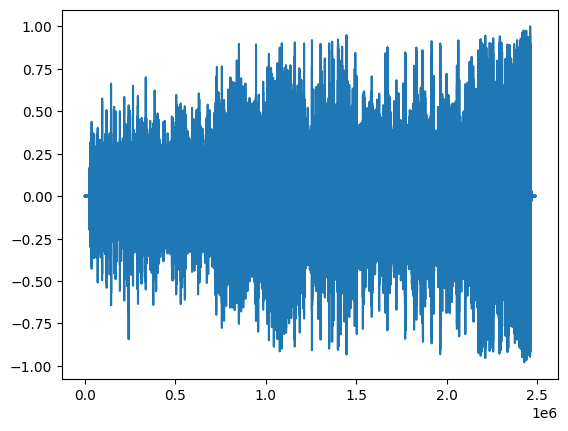

In [164]:
plt.plot(y)

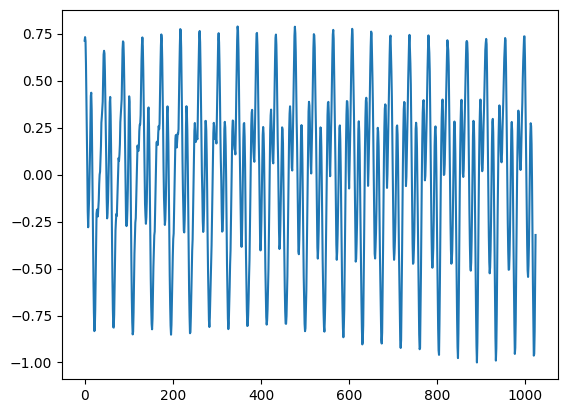

In [165]:
start_frame = 300000
y_frame = y[start_frame:start_frame+1024]
y_frame = y_frame / np.max(np.abs(y_frame))
plt.plot(y_frame)

In [166]:
Audio(y_frame, rate = sr)

In [176]:
y_clipped = clip(y_frame, 0.5)

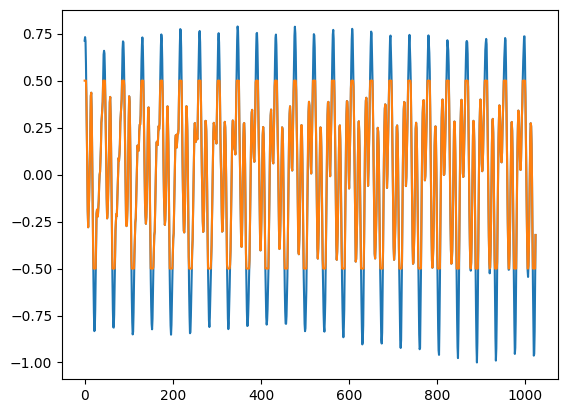

In [177]:
plt.plot(y_frame)
plt.plot(y_clipped)


In [178]:
Audio(y_clipped, rate = sr)

In [179]:
y_reconstructed = OMP(y_clipped, 150, 1e-6, theta_clip = .5, theta_max = 1.05)[0]

Iteration 0: residual norm 44.20595.
Iteration 1: residual norm 39.97749.
Iteration 2: residual norm 35.26573.
Iteration 3: residual norm 44.00212.
Iteration 4: residual norm 24.25273.
Iteration 5: residual norm 16.68227.
Iteration 6: residual norm 9.88583.
Iteration 7: residual norm 8.21478.
Iteration 8: residual norm 7.44954.
Iteration 9: residual norm 7.01204.
Iteration 10: residual norm 6.45263.
Iteration 11: residual norm 5.96234.
Iteration 12: residual norm 5.74097.
Iteration 13: residual norm 5.00214.
Iteration 14: residual norm 4.67702.
Iteration 15: residual norm 4.44886.
Iteration 16: residual norm 4.27545.
Iteration 17: residual norm 4.03948.
Iteration 18: residual norm 3.80820.
Iteration 19: residual norm 3.63445.
Iteration 20: residual norm 3.49749.
Iteration 21: residual norm 3.31730.
Iteration 22: residual norm 3.14791.
Iteration 23: residual norm 3.03935.
Iteration 24: residual norm 2.90697.
Iteration 25: residual norm 2.76270.
Iteration 26: residual norm 2.64934.
Itera

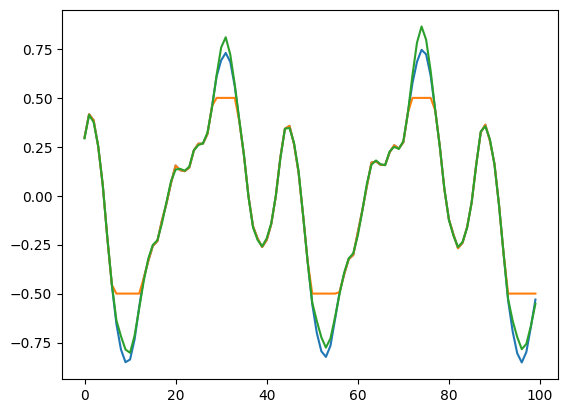

In [180]:
plt.plot(y_frame[100:200])
plt.plot(y_clipped[100:200])
plt.plot(y_reconstructed[100:200])

In [181]:
Audio(y_reconstructed, rate = sr)

In [182]:
Audio(y_frame, rate = sr)

### Speech Dataset

In [7]:
path_speech = 'C-OMP-for-Audio-Declipping/LJSpeech-1.1'

#### Exploratory Data Analysis

## Experiments

In [222]:
# Idees
## SNR_m vs theta_clip
## Impact of lambda_reg ?
## Performance on music vs Speech
## Performance on smooth vs non-smooth signals (eg : accordion vs celo)